In [1]:
import numpy as np
import os
import pandas as pd
import sys
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Activation, Add, Multiply, Lambda
from tensorflow.keras.models import Model
sns.set()

In [2]:
class ProgressTracker:
    def __init__(self, total_steps, epochs = ''):
        self.total_steps = total_steps
        self.current_step = 0
        self.epochs = epochs

    def update(self, increment=1, loss = ""):
        self.current_step += increment
        self.print_progress(loss)

    def print_progress(self, loss):
        progress_percent = (self.current_step / self.total_steps) * 100
        progress_bar_length = 30
        num_completed = int(progress_percent / (100 / progress_bar_length))
        num_remaining = progress_bar_length - num_completed
        progress_bar = self.epochs + " [" + "=" * num_completed +">>" +" " * num_remaining + "]"

        if(loss == ""):
            sys.stdout.write(f"\rProgress: {progress_bar} {progress_percent:.2f}% ({self.current_step}/{self.total_steps}) {loss}")
        else:
            sys.stdout.write(f"\r{progress_bar} {progress_percent:.2f}% ({self.current_step}/{self.total_steps}) {loss}")

        sys.stdout.flush()
        if(progress_percent == 100):
          print()

In [3]:
class DatasetPreProcessing:

  # init function
  def __init__(self, stockPath, bondRatePath, underlying = 'SPX'):
    self.stockPath=stockPath
    self.bondRatePath=bondRatePath
    self.underlying = underlying


  # function to get join dataset of stock and options dataset

  def getOptionsStockDataset(self, no_of_month = 1):
    # stockPath ----> path of folder containing stock and options data
    # no_of_month ----> no of month for which we have to create a dataframe which will be join dataframe of stock and options

    main_folder = self.stockPath

    # List to store options and stock DataFrames
    options_dataframes = []
    stock_dataframes = []

    # Iterate through each month's folder
    i=0
    for month_folder in os.listdir(main_folder):
        i+=1
        if(i==no_of_month+1):
          break
        month_path = os.path.join(main_folder, month_folder)

        # List to store options and stock DataFrames for each day
        day_options_dataframes = []
        day_stock_dataframes = []

        # Iterate through each day's folder
        for day_folder in os.listdir(month_path):
            day_path = os.path.join(month_path, day_folder)

            # Load options data for the day
            # Load options and stock data for the day
            if 'options' in day_folder:
              options_data = pd.read_csv(day_path)
              options_data = options_data[options_data['underlying'] == self.underlying].copy()
              options_data=options_data.drop(columns=['bid_size','ask_size','contract','style'])
              options_data.rename(columns={'volume': 'v_options'}, inplace=True)
              options_dataframes.append(options_data)
            else:
              # Load stock data for the day
              stock_data = pd.read_csv(day_path)
              stock_data = stock_data[stock_data['symbol'] == self.underlying].copy()
              stock_data = stock_data.drop(columns=["adjust_close"])
              stock_data.rename(columns={'volume': 'v_stocks'}, inplace=True)
              stock_data['date'] = day_folder[:10]  # Add a new column for the date
              stock_dataframes.append(stock_data)
            self.tracker.update()

    # Union of all options data
    options_union = pd.concat(options_dataframes, ignore_index=True)

    # Union of all stock data
    stock_union = pd.concat(stock_dataframes, ignore_index=True)

    # Perform the join of stock and options data
    large_dataframe = pd.merge(stock_union, options_union, left_on=['date', 'symbol'], right_on=['expiration', 'underlying'], how='inner')


    # Calculate the number of days before expiration
    large_dataframe['expiration_date'] = pd.to_datetime(large_dataframe['expiration'])
    large_dataframe['quote_date'] = pd.to_datetime(large_dataframe['quote_date'])
    large_dataframe['days_before_expiration'] = (large_dataframe['expiration_date'] - large_dataframe['quote_date']).dt.days



    # Perform the join of large_dataframe and stock_union to get current values of stock for the quote_date in large_dataframe
    temp=stock_union[['date', 'symbol', 'open']].copy()
    temp['date'] = pd.to_datetime(temp['date'])
    temp.rename(columns={'date': 'd'}, inplace=True)
    temp.rename(columns={'symbol': 's'}, inplace=True)
    temp.rename(columns={'open': 'current_val'}, inplace=True)



    # Merge large_dataframe and stock_union based on the conditions
    large_dataframe = pd.merge(
        large_dataframe,
        temp,
        left_on=['quote_date', 'underlying'],
        right_on=['d', 's'],
        how='inner'
    )





    # Drop unnecessary columns
    large_dataframe.drop(['d', 's'], axis=1, inplace=True)

    return large_dataframe


  def getBondRateDataframe(self):
    # Read the 'Sheet1' sheet and skip the first row
    bondRateDataFrame = pd.read_excel(self.bondRatePath,header=None)
    bondRateDataFrame.columns = ["date","r"]

    return bondRateDataFrame


  def margeLargeAndBond(self, largeDataframe, bondFrame):

    largeDataframe = pd.merge(largeDataframe, bondFrame, left_on=['quote_date'], right_on=["date"], how='inner')

    return largeDataframe


  def filtring(self, largeDataFrame, min_vOptions, min_OI, type_, min_bid, maxStrickCurrentValRatio, maxDayBeforeExpiration, minDayBeforeExpiration):
    # Keep only rows where type is 'call' and  'underlying' column to 'A'
    filtered_dataframe = largeDataFrame[largeDataFrame['type'] == type_]
    filtered_dataframe = filtered_dataframe[filtered_dataframe['v_options']>=min_vOptions]
    filtered_dataframe = filtered_dataframe[filtered_dataframe['open_interest']>min_OI]
    filtered_dataframe = filtered_dataframe[filtered_dataframe['bid']>min_bid]
    filtered_dataframe = filtered_dataframe[
        filtered_dataframe['bid'] > filtered_dataframe['strike'] - filtered_dataframe['current_val'] * np.exp(filtered_dataframe['r'] * filtered_dataframe['days_before_expiration'])
    ]
    filtered_dataframe = filtered_dataframe[filtered_dataframe['strike']/filtered_dataframe['current_val']<maxStrickCurrentValRatio]

    filtered_dataframe = filtered_dataframe[filtered_dataframe["days_before_expiration"] <= maxDayBeforeExpiration]
    filtered_dataframe = filtered_dataframe[minDayBeforeExpiration <= filtered_dataframe["days_before_expiration"]]




    return filtered_dataframe

  def run(self, no_of_month = 1, min_vOptions=1, min_OI=10, type_="call", min_bid=1, maxStrickCurrentValRatio=1.7, maxDayBeforeExpiration=7, minDayBeforeExpiration=2):

    self.tracker = ProgressTracker(no_of_month*28*2)
    stockOptionFrame = self.getOptionsStockDataset(no_of_month)
    print("\r<========== getOptionsStockDataset : Done ==========>")
    print()
    bondFrame = self.getBondRateDataframe()
    print("<========== getBondRateDataframe : Done ==========>")
    print()
    margeFrame = self.margeLargeAndBond(stockOptionFrame, bondFrame)
    print("<========== margeLargeAndBond : Done ==========>")
    print()
    filteredFrame = self.filtring(margeFrame, min_vOptions, min_OI, type_, min_bid, maxStrickCurrentValRatio, maxDayBeforeExpiration, minDayBeforeExpiration)
    print("<========== filtring : Done ==========>")
    print()
    return filteredFrame


In [4]:

class DataTraining:

  def __init__(self, model , dataframe):
    self.model = model
    self.dataframe = dataframe

    # it is a variable to save if we want to split data to train test val in continues or shhufled form
    self.cont = None

  def getInputOutput(self, filtered_dataframe, input_columns
                     , output_columns, cont):
    if(cont == False):
      self.cont = False
      # Shuffle the DataFrame
      shuffled_dataframe = filtered_dataframe.sample(frac=1, random_state=42).reset_index(drop=True)

      # Define input and output data
      input_data = shuffled_dataframe[input_columns]
      output_data = shuffled_dataframe[output_columns]

    else:
      self.cont = True
      filtered = filtered_dataframe[filtered_dataframe['days_before_expiration'] <= 4].copy()
      grouped = filtered.groupby(['expiration_date', 'strike'])

      output = []
      input_matrix = []
      for group, group_df in grouped:
            print(group,1)
            if(filtered[(filtered['expiration_date'] == group[0]) & (filtered['strike'] == group[1]) & (filtered['days_before_expiration'] == 4)].empty == False ):
              if(filtered[(filtered['expiration_date'] == group[0]) & (filtered['strike'] == group[1]) & (filtered['days_before_expiration'] == 3)].empty == False):
                if(filtered[(filtered['expiration_date'] == group[0]) & (filtered['strike'] == group[1]) & (filtered['days_before_expiration'] == 2)].empty == False):
                  print(group,0)

                  output.append(filtered[(filtered['expiration_date'] == group[0]) & (filtered['strike'] == group[1]) & (filtered['days_before_expiration'] == 4)].iloc[0]['close'])

                  channel_1 = np.array(filtered[(filtered['expiration_date'] == group[0]) & (filtered['strike'] == group[1])][['gamma', 'theta', 'delta', 'vega', 'implied_volatility']].values)
                  channel_2 = np.array(filtered[(filtered['expiration_date'] == group[0]) & (filtered['strike'] == group[1])][['open', 'high', 'low', 'close', 'v_stocks']].values)
                  # Stack the matrices along the channel axis (axis 1)
                  stacked_data = np.stack((channel_1, channel_2), axis=1)
                  # Reshape the stacked data to have 1 height and 5 width
                  reshaped_data = stacked_data.reshape(stacked_data.shape[0], stacked_data.shape[1], 1, stacked_data.shape[2])
                  input_matrix.append(reshaped_data)

      output_data = np.array(output)
      input_data = np.array(input_matrix)


    return input_data,output_data


  def getTrainTesVal(self, input_data, output_data,train_ratio, test_ratio, val_ratio, scaler):

      # Normalize input data using Min-Max scaling
    if(self.cont == False):
        input_data_normalized = scaler.fit_transform(input_data)
        output_data_noramlized = output_data.copy()
        self.scaler = scaler
        for column in output_data.columns:
            max_val = output_data[column].max()
            min_val = output_data[column].min()
            output_data_noramlized[column] = (output_data[column] - min_val) / (max_val - min_val)

        self.output_scaler = [min_val, max_val]
    else:
        output_data_noramlized = scaler.fit_transform(output_data.reshape(-1,1))
        self.output_scaler = scaler

        input_data_normalized = input_data.copy()




    input_train, input_temp, output_train, output_temp = train_test_split(input_data_normalized, output_data_noramlized, test_size=1 - train_ratio, random_state=42)
    input_test, input_val, output_test, output_val = train_test_split(input_temp, output_temp, test_size=test_ratio / (test_ratio + val_ratio), random_state=42)


    # Print the shapes of the datasets
    print("<<<<<<============================================================>>>>>>")
    print("Input shapes:")
    print("Training:", input_train.shape)
    print("Testing:", input_test.shape)
    print("Validation:", input_val.shape)
    print("\nOutput shapes:")
    print("Training:", output_train.shape)
    print("Testing:", output_test.shape)
    print("Validation:", output_val.shape)
    print("<<<<<<============================================================>>>>>>")
    print()


    return input_train, output_train, input_test, input_val, output_test, output_val

  def train(self, model, input_train, output_train, input_test, input_val, output_test, output_val
            ):
    model.run([input_train, output_train], test=[input_test, output_test], val = [input_val, output_val])

    # Make predictions
    predictions_train = model.predict(input_train)
    predictions_test = model.predict(input_test)
    predictions_val = model.predict(input_val)

    return predictions_train, predictions_test, predictions_val

  def run(self, cont, model = None, input_columns=['strike', 'days_before_expiration', 'current_val','r','implied_volatility']
                     , output_columns=['close'],  train_ratio = 0.7,
          test_ratio = 0.15, val_ratio = 0.15, scaler=MinMaxScaler()):

    if(model is None):
      model = self.model
    input_data, output_data = self.getInputOutput(self.dataframe, input_columns
                     , output_columns, cont)

    self.input_data = input_data
    self.output_data = output_data

    print("<========== getInputOutput : Done ==========>")
    print()

    input_train, output_train, input_test, input_val, output_test, output_val = self.getTrainTesVal(input_data,
                                                                                  output_data,train_ratio, test_ratio, val_ratio, scaler)

    print("<========== getTrainTesVal : Done ==========>")
    print()

    self.input_train, self.output_train, self.input_test, self.input_val, self.output_test, self.output_val = input_train, output_train, input_test, input_val, output_test, output_val



    predictions_train, predictions_test, predictions_val = self.train(model, input_train, output_train, input_test, input_val, output_test, output_val)

    print("<========== train : Done ==========>")
    print()
    if(self.cont == True):
      return None

    self.predictions_train, self.predictions_test, self.predictions_val = predictions_train, predictions_test, predictions_val


    return scaler.inverse_transform(input_test)





In [5]:
# Path to the main folder containing all months
stockPath = '/content/drive/MyDrive/MTP project/Data'
bondRatePath = "/content/Untitled spreadsheet.xlsx"

preprocessing = DatasetPreProcessing(stockPath, bondRatePath, underlying = "AAPL")
filtered_frame = preprocessing.run(no_of_month = 1)

<========== getOptionsStockDataset : Done ==========>

<========== getBondRateDataframe : Done ==========>

<========== margeLargeAndBond : Done ==========>

<========== filtring : Done ==========>



In [6]:
filtered_frame.shape

(174, 26)

In [7]:
class SVRModel:
    def __init__(self, kernel = 'rbf', C = 1.0, epsilon = 1.0, tol = 1e-4, gamma= 1/5):
        self.kernel = kernel
        self.gamma = gamma
        self.C = C
        self.epsilon = epsilon
        self.tol = tol

        self.model = SVR(kernel = self.kernel, gamma = self.gamma, C = self.C ,epsilon = self.epsilon, tol = self.tol)


    def fit(self, X, y):
        self.model.fit(X, y)



    def predict(self, X):
        return self.model.predict(X)

    def evaluate(self, X_test, y_test):
        y_pred = self.predict(X_test)
        mse = mean_squared_error(y_test, y_pred)
        print("<<<<<<============================================================>>>>>>")
        print("Mean Squared Error (MSE):", mse)
        print("<<<<<<============================================================>>>>>>")
        return mse

    def run(self, train, test, val):


      input_test, output_test = test
      input_val, output_val = val
      input_train, output_train = train

      self.fit(input_train, output_train)

      predictions_train = self.predict(input_train)
      predictions_test = self.predict(input_test)
      predictions_val = self.predict(input_val)




    # Calculate Mean Squared Error
      mse_train = mean_squared_error(output_train, predictions_train)
      mse_test = mean_squared_error(output_test, predictions_test)
      mse_val = mean_squared_error(output_val, predictions_val)

      print("<<<<<<============================================================>>>>>>")
      print("Mean Squared Error (Training):", mse_train)
      print("Mean Squared Error (Testing):", mse_test)
      print("Mean Squared Error (Validation):", mse_val)
      print("<<<<<<============================================================>>>>>>")

      return mse_train, mse_test, mse_val




In [8]:
model = SVRModel(kernel='rbf', gamma=1/5, C=20 ,epsilon=0.2, tol=1e-4)
training = DataTraining(model, filtered_frame)
val_data=training.run(False)

<========== getInputOutput : Done ==========>

<<<<<<============================================================>>>>>>
Input shapes:
Training: (121, 5)
Testing: (26, 5)
Validation: (27, 5)

Output shapes:
Training: (121, 1)
Testing: (26, 1)
Validation: (27, 1)
<<<<<<============================================================>>>>>>

<========== getTrainTesVal : Done ==========>

<<<<<<============================================================>>>>>>
Mean Squared Error (Training): 0.021091724231205616
Mean Squared Error (Testing): 0.020209997272743495
Mean Squared Error (Validation): 0.020385022981520222
<<<<<<============================================================>>>>>>
<========== train : Done ==========>



/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [9]:
class MLP:
    def __init__(self, input_dim, hidden_units=[100, 100], output_dim=1,
                 initializer='glorot_normal', activation='tanh', loss='mean_squared_error',
                 learning_rate=0.00001, batchsize=1, epochs = 200):

        self.activation = activation
        self.loss = loss
        self.initializer = initializer
        self.learning_rate = learning_rate
        self.batchsize = batchsize
        self.model = tf.keras.Sequential()
        self.epochs = epochs

        for i in hidden_units:
            self.model.add(tf.keras.layers.Dense(i, activation=self.activation, input_shape=(input_dim,)))
        self.model.add(tf.keras.layers.Dense(output_dim))

        self.model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=self.learning_rate),
                           loss=self.loss)

    def fit(self, X_train, y_train, epochs = 200, batch_size = 1, verbose = 'auto', validation_data = None):
        history = self.model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=verbose,
                                 validation_data=validation_data)

        val_mse = history.history['loss']
        plt.plot(range(1, epochs + 1), val_mse, label='Training MSE')
        plt.xlabel('Epochs')
        plt.ylabel('Training MSE')
        plt.legend()
        plt.show()

        if validation_data:
            val_mse = history.history['val_loss']
            plt.plot(range(1, epochs + 1), val_mse, label='Validation MSE')
            plt.xlabel('Epochs')
            plt.ylabel('Validation MSE')
            plt.legend()
            plt.show()

    def predict(self, X):
        return self.model.predict(X)

    def evaluate(self, X_test, y_test):
        y_pred = self.predict(X_test)
        mse = mean_squared_error(y_test, y_pred)
        print("<<<<<<============================================================>>>>>>")
        print("Mean Squared Error (MSE):", mse)
        print("<<<<<<============================================================>>>>>>")
        return mse

    def run(self, train, test, val, batch_size = 1, verbose = 'auto'):

      epochs = self.epochs

      input_test, output_test = test
      input_val, output_val = val
      input_train, output_train = train

      self.fit(input_train, output_train, epochs, batch_size, verbose, validation_data = val)

      predictions_train = self.predict(input_train)
      predictions_test = self.predict(input_test)
      predictions_val = self.predict(input_val)


      # Calculate Mean Squared Error
      mse_train = mean_squared_error(output_train, predictions_train)
      mse_test = mean_squared_error(output_test, predictions_test)
      mse_val = mean_squared_error(output_val, predictions_val)

      print("<<<<<<=======================================>>>>>>")
      print("Mean Squared Error (Training):", mse_train)
      print("Mean Squared Error (Testing):", mse_test)
      print("Mean Squared Error (Validation):", mse_val)
      print("<<<<<<=======================================>>>>>>")

      return mse_train, mse_test, mse_val
    def summary(self):
      print(self.model.summary())



In [ ]:
model = MLP(5,hidden_units = [50, 50, 50])
model.summary()
training = DataTraining(model, filtered_frame)
val_data=training.run(False)

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_9 (Dense)             (None, 50)                300       
                                                                 
 dense_10 (Dense)            (None, 50)                2550      
                                                                 
 dense_11 (Dense)            (None, 50)                2550      
                                                                 
 dense_12 (Dense)            (None, 1)                 51        
                                                                 
Total params: 5451 (21.29 KB)
Trainable params: 5451 (21.29 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
<========== getInputOutput : Done ==========>

<<<<<<============================================================>>>>>>
Input shapes:
Training: (12

In [ ]:
import tensorflow as tf

class Network(object):
    '''
    This class contains code for a simple feed forward neural network
    '''
    def __init__(self, input_dim, hidden_units=[100, 100], output_dim=1,
                 initializer='glorot_normal', activation='tanh', loss='mean_squared_error',
                 learning_rate=0.00001, batchsize = 1 ,epochs = 200):


        self.activation = activation
        self.input_dim = input_dim
        self.hidden_units = hidden_units
        self.output_dim = output_dim
        self.initializer = initializer
        self.learning_rate = learning_rate
        self.batchsize = batchsize
        self.model = tf.keras.Sequential()
        self.epochs = epochs

        # store the parameters of the network
        self.params = []


        self.params.append(tf.random.normal([input_dim, hidden_units[0]], stddev=0.1))
        self.params.append(tf.Variable(tf.zeros([1, hidden_units[0]])))

        for i in range(1,len(hidden_units)):
          self.params.append(tf.random.normal([hidden_units[i-1], hidden_units[i]], stddev=0.1)
            )

          self.params.append(tf.Variable(tf.zeros([1, hidden_units[i]])))

        self.params.append(tf.random.normal([hidden_units[-1], output_dim], stddev=0.1))
        self.params.append(tf.Variable(tf.zeros([1, output_dim])))


    def forward(self, x):


        X_tf = tf.cast(x,dtype=tf.float32)


        for i in range(0,len(self.params),2):
          temp = tf.matmul(X_tf, self.params[i]) + self.params[i+1]
          temp = tf.nn.tanh(temp)
          X_tf = temp

        return temp

    def loss(self, y_true, logits):
        '''
        logits - Tensor of shape (batch_size, size_output)
        y_true - Tensor of shape (batch_size, size_output)
        '''
        y_true_tf = tf.cast(tf.reshape(y_true, (-1, 1)), dtype=tf.float32)
        logits_tf = tf.cast(tf.reshape(logits, (-1, 1)), dtype=tf.float32)
        return tf.compat.v1.losses.sigmoid_cross_entropy(y_true_tf, logits_tf)

    def backward(self, x, y):
        optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate= self.learning_rate)
        with tf.GradientTape() as tape:
            predicted = self.forward(x)
            current_loss = self.loss(y, predicted)
        grads = tape.gradient(current_loss, self.params)
        optimizer.apply_gradients(zip(grads, self.params),
                                  global_step=tf.compat.v1.train.get_or_create_global_step())
        return current_loss

    def fit(self, X_train, y_train, epochs = 200, batch_size = 1, verbose = 'auto', validation_data = None):

        if(validation_data != None):
          input_val, output_val = validation_data

        if (verbose != None):
            train_loss_tracker = []
            if validation_data!=None:
                val_loss_tracker = []


        for epoch in range(epochs):
            if verbose:
                if(X_train.shape[0] % batch_size == 0):
                    tracker = ProgressTracker(X_train.shape[0]//batch_size, epochs = "epoch"+str(epoch+1)+"/"+str(epochs))
                else:
                    tracker = ProgressTracker(X_train.shape[0]//batch_size)




            for i in range(0, X_train.shape[0], batch_size):
                x_batch = X_train[i:i + batch_size]
                y_batch = y_train[i:i + batch_size]

                if(verbose):
                    training_loss = self.backward(x_batch,y_batch)

                    if validation_data != None:
                        predictions_val = self.predict(input_val)
                        mse_val = self.loss(output_val, predictions_val)
                        tracker.update(loss = "train_loss : "+ "{:.6f}".format(training_loss.numpy()) + "  val_loss : "+ "{:.6f}".format(mse_val.numpy()))
                    else:
                        tracker.update(loss = "train_loss :"+ "{:.6f}".format(training_loss.numpy()))


            if (verbose != None):
                train_loss_tracker.append(training_loss.numpy())


                if validation_data!=None:
                    val_loss_tracker.append(mse_val.numpy())

        print(val_loss_tracker)
        print(train_loss_tracker)
        if (verbose != None):
          val_mse = train_loss_tracker
          plt.plot(range(1, epochs + 1), val_mse, label='Training MSE')
          plt.xlabel('Epochs')
          plt.ylabel('Training MSE')
          plt.legend()
          plt.show()

          if validation_data:
              val_mse = val_loss_tracker
              plt.plot(range(1, epochs + 1), val_mse, label='Validation MSE')
              plt.xlabel('Epochs')
              plt.ylabel('Validation MSE')
              plt.legend()
              plt.show()

    def predict(self, X):
        return self.forward(X)

    def evaluate(self, X_test, y_test):
        y_pred = self.predict(X_test)
        mse = mean_squared_error(y_test, y_pred)
        print("<<<<<<============================================================>>>>>>")
        print("Mean Squared Error (MSE):", mse)
        print("<<<<<<============================================================>>>>>>")
        return mse

    def run(self, train, test, val, batch_size = 1, verbose = 'auto'):

      epochs = self.epochs

      input_test, output_test = test
      input_val, output_val = val
      input_train, output_train = train

      input_test = tf.convert_to_tensor(input_test, dtype=tf.float32)
      output_test = tf.convert_to_tensor(output_test, dtype=tf.float32)
      input_val = tf.convert_to_tensor(input_val, dtype=tf.float32)
      output_val = tf.convert_to_tensor(output_val, dtype=tf.float32)
      input_train = tf.convert_to_tensor(input_train, dtype=tf.float32)
      output_train = tf.convert_to_tensor(output_train, dtype=tf.float32)

      self.fit(input_train, output_train, epochs, batch_size, verbose, validation_data = [input_val, output_val])

      predictions_train = self.predict(input_train)
      predictions_test = self.predict(input_test)
      predictions_val = self.predict(input_val)


      # Calculate Mean Squared Error
      mse_train = mean_squared_error(output_train, predictions_train)
      mse_test = mean_squared_error(output_test, predictions_test)
      mse_val = mean_squared_error(output_val, predictions_val)

      print("<<<<<<=======================================>>>>>>")
      print("Mean Squared Error (Training):", mse_train)
      print("Mean Squared Error (Testing):", mse_test)
      print("Mean Squared Error (Validation):", mse_val)
      print("<<<<<<=======================================>>>>>>")

      return mse_train, mse_test, mse_val


<========== getInputOutput : Done ==========>

<<<<<<============================================================>>>>>>
Input shapes:
Training: (132, 5)
Testing: (29, 5)
Validation: (29, 5)

Output shapes:
Training: (132, 1)
Testing: (29, 1)
Validation: (29, 1)
<<<<<<============================================================>>>>>>

<========== getTrainTesVal : Done ==========>

epoch1/5 [==============================>>] 100.00% (132/132) train_loss : 0.656569  val_loss : 0.662756
epoch2/5 [==============================>>] 100.00% (132/132) train_loss : 0.649603  val_loss : 0.661690
epoch3/5 [==============================>>] 100.00% (132/132) train_loss : 0.642708  val_loss : 0.660689
epoch4/5 [==============================>>] 100.00% (132/132) train_loss : 0.635886  val_loss : 0.659754
epoch5/5 [==============================>>] 100.00% (132/132) train_loss : 0.629140  val_loss : 0.658885
[0.6627558, 0.66168964, 0.660689, 0.65975416, 0.6588853]
[0.65656906, 0.64960283, 0.6427076,

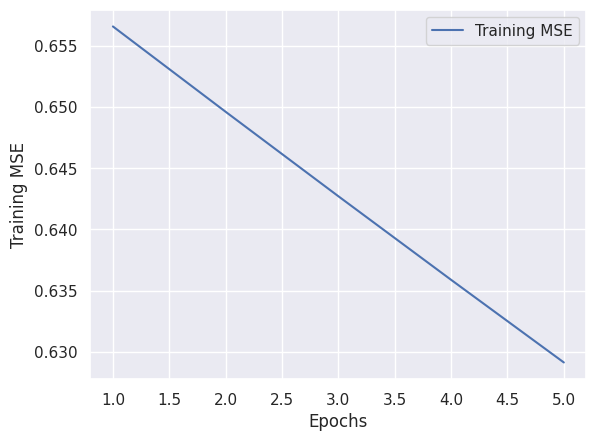

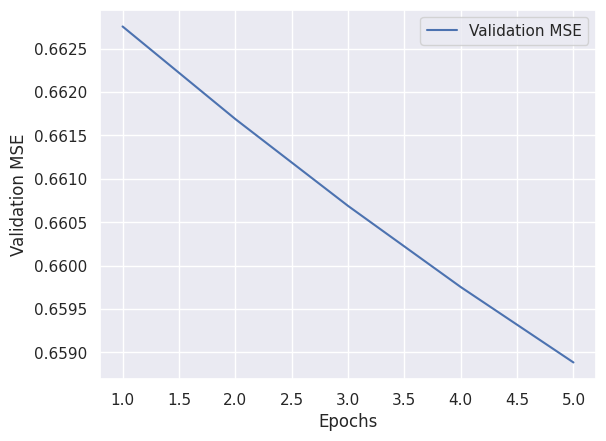

<<<<<<=======================================>>>>>>
Mean Squared Error (Training): 0.44851464
Mean Squared Error (Testing): 0.47927663
Mean Squared Error (Validation): 0.41703394
<<<<<<=======================================>>>>>>
<========== train : Done ==========>



In [ ]:
model = Network(5, epochs = 5, learning_rate=0.0001)
training = DataTraining(model, filtered_frame)
val_data=training.run(False)

In [ ]:
class HighwayLayer(tf.keras.layers.Layer):
    def __init__(self, activation='tanh', carry_bias=-2.0, **kwargs):
        super(HighwayLayer, self).__init__(**kwargs)
        self.activation = tf.keras.activations.get(activation)
        self.carry_bias = carry_bias

    def build(self, input_shape):
        input_dim = input_shape[-1]
        # Weight matrices and biases for transformation and carry gates
        self.W_transform = self.add_weight("W_transform", shape=(input_dim, input_dim), trainable=True)
        self.b_transform = self.add_weight("b_transform", shape=(input_dim,), trainable=True)
        self.W_carry = self.add_weight("W_carry", shape=(input_dim, input_dim), trainable=True)
        self.b_carry = self.add_weight("b_carry", shape=(input_dim,), trainable=True)
        super(HighwayLayer, self).build(input_shape)

    def call(self, inputs):
        # Transformation gate
        transform_gate = self.activation(tf.matmul(inputs, self.W_transform) + self.b_transform)
        # Carry gate
        carry_gate = tf.sigmoid(tf.matmul(inputs, self.W_carry) + self.b_carry + self.carry_bias)
        # Compute the output
        output = carry_gate * inputs + (1 - carry_gate) * transform_gate
        return output

    def compute_output_shape(self, input_shape):
        return input_shape

In [ ]:
class HighwayNetwork:
    def __init__(self, input_dim, hidden_units=[100, 3], output_dim=1,
                 initializer='glorot_normal', activation='tanh', loss='mean_squared_error',
                 learning_rate=0.00001, batchsize=1, epochs = 200):

        self.activation = activation
        self.loss = loss
        self.initializer = initializer
        self.learning_rate = learning_rate
        self.batchsize = batchsize
        self.model = tf.keras.Sequential()
        self.epochs = epochs


        self.model.add(tf.keras.layers.Dense(hidden_units[0], activation=self.activation, input_shape=(input_dim,)))
        for i in range(hidden_units[1]):
          self.model.add(HighwayLayer(activation = self.activation))
        self.model.add(tf.keras.layers.Dense(output_dim))

        self.model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=self.learning_rate),
                           loss=self.loss)

    def fit(self, X_train, y_train, epochs = 200, batch_size = 1, verbose = 'auto', validation_data = None):
        history = self.model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=verbose,
                                 validation_data=validation_data)

        val_mse = history.history['loss']
        plt.plot(range(1, epochs + 1), val_mse, label='Training MSE')
        plt.xlabel('Epochs')
        plt.ylabel('Training MSE')
        plt.legend()
        plt.show()

        if validation_data:
            val_mse = history.history['val_loss']
            plt.plot(range(1, epochs + 1), val_mse, label='Validation MSE')
            plt.xlabel('Epochs')
            plt.ylabel('Validation MSE')
            plt.legend()
            plt.show()

    def predict(self, X):
        return self.model.predict(X)

    def evaluate(self, X_test, y_test):
        y_pred = self.predict(X_test)
        mse = mean_squared_error(y_test, y_pred)
        print("<<<<<<============================================================>>>>>>")
        print("Mean Squared Error (MSE):", mse)
        print("<<<<<<============================================================>>>>>>")
        return mse

    def run(self, train, test, val, batch_size = 1, verbose = 'auto'):

      epochs = self.epochs

      input_test, output_test = test
      input_val, output_val = val
      input_train, output_train = train

      self.fit(input_train, output_train, epochs, batch_size, verbose, validation_data = val)

      predictions_train = self.predict(input_train)
      predictions_test = self.predict(input_test)
      predictions_val = self.predict(input_val)


      # Calculate Mean Squared Error
      mse_train = mean_squared_error(output_train, predictions_train)
      mse_test = mean_squared_error(output_test, predictions_test)
      mse_val = mean_squared_error(output_val, predictions_val)

      print("<<<<<<=======================================>>>>>>")
      print("Mean Squared Error (Training):", mse_train)
      print("Mean Squared Error (Testing):", mse_test)
      print("Mean Squared Error (Validation):", mse_val)
      print("<<<<<<=======================================>>>>>>")

      return mse_train, mse_test, mse_val
    def summary(self):
      print(self.model.summary())



Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 100)               600       
                                                                 
 highway_layer (HighwayLaye  (None, 100)               20200     
 r)                                                              
                                                                 
 highway_layer_1 (HighwayLa  (None, 100)               20200     
 yer)                                                            
                                                                 
 highway_layer_2 (HighwayLa  (None, 100)               20200     
 yer)                                                            
                                                                 
 dense_4 (Dense)             (None, 1)                 101       
                                                      

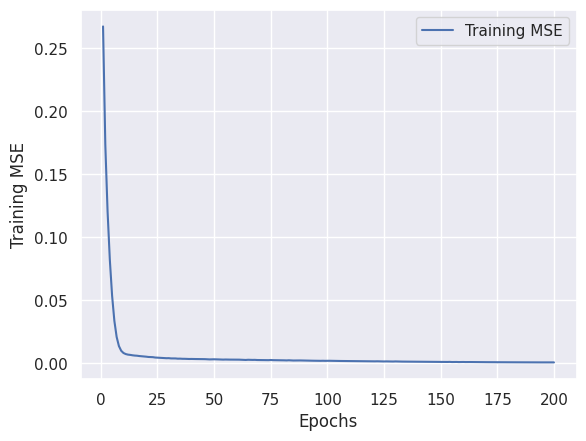

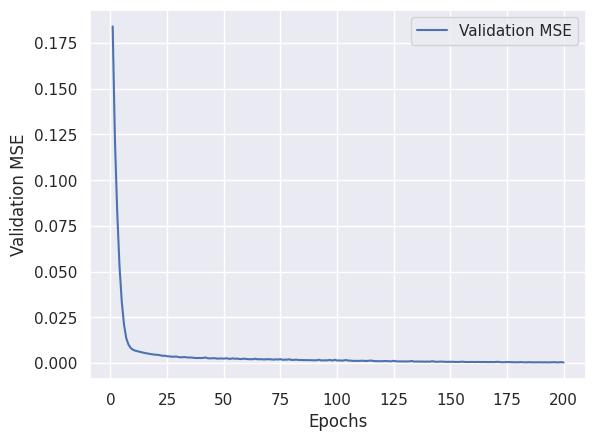

1/1 [==============================] - 0s 20ms/step
<<<<<<=======================================>>>>>>
Mean Squared Error (Training): 0.0005306380652586089
Mean Squared Error (Testing): 0.0002439796310767733
Mean Squared Error (Validation): 0.0003374636121460932
<<<<<<=======================================>>>>>>
1/1 [==============================] - 0s 20ms/step
<========== train : Done ==========>



In [ ]:
model = HighwayNetwork(5)
model.summary()
training = DataTraining(model, filtered_frame)
val_data=training.run(False)

In [ ]:
class GenralizedHighwayLayer(tf.keras.layers.Layer):
    def __init__(self, activation='tanh', carry_bias=-2.0,transform_bais = -2.0, **kwargs):
        super(GenralizedHighwayLayer, self).__init__(**kwargs)
        self.activation = tf.keras.activations.get(activation)
        self.carry_bias = carry_bias
        self.transform_bais = transform_bais

    def build(self, input_shape):
        input_dim = input_shape[-1]
        # Weight matrices and biases for transformation and carry gates
        self.W_transform = self.add_weight("W_transform", shape=(input_dim, input_dim), trainable=True)
        self.b_transform = self.add_weight("b_transform", shape=(input_dim,), trainable=True)
        self.W_carry_gate = self.add_weight("W_carry_gate", shape=(input_dim, input_dim), trainable=True)
        self.b_carry_gate = self.add_weight("b_carry_gate", shape=(input_dim,), trainable=True)
        self.W_transform_gate = self.add_weight("W_transform_gate", shape=(input_dim, input_dim), trainable=True)
        self.b_transform_gate = self.add_weight("b_transform_gate", shape=(input_dim,), trainable=True)
        super(GenralizedHighwayLayer, self).build(input_shape)

    def call(self, inputs):
        # Transformation
        transform = self.activation(tf.matmul(inputs, self.W_transform) + self.b_transform)
        # Carry gate
        carry_gate = tf.sigmoid(tf.matmul(inputs, self.W_carry_gate) + self.b_carry_gate + self.carry_bias)
        # transform gate
        transform_gate = tf.sigmoid(tf.matmul(inputs, self.W_transform_gate) + self.b_transform_gate + self.transform_bais)
        # Compute the output
        output = carry_gate * inputs + (transform_gate) * transform
        return output

    def compute_output_shape(self, input_shape):
        return input_shape

In [ ]:
class GenralizedHighwayNetwork:
    def __init__(self, input_dim, hidden_units=[100, 3], output_dim=1,
                 initializer='glorot_normal', activation='tanh', loss='mean_squared_error',
                 learning_rate=0.00001, batchsize=1, epochs = 200):

        self.activation = activation
        self.loss = loss
        self.initializer = initializer
        self.learning_rate = learning_rate
        self.batchsize = batchsize
        self.model = tf.keras.Sequential()
        self.epochs = epochs


        self.model.add(tf.keras.layers.Dense(hidden_units[0], activation=self.activation, input_shape=(input_dim,)))
        for i in range(hidden_units[1]):
          self.model.add(GenralizedHighwayLayer(activation = self.activation))
        self.model.add(tf.keras.layers.Dense(output_dim))

        self.model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=self.learning_rate),
                           loss=self.loss)

    def fit(self, X_train, y_train, epochs = 200, batch_size = 1, verbose = 'auto', validation_data = None):
        history = self.model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=verbose,
                                 validation_data=validation_data)

        val_mse = history.history['loss']
        plt.plot(range(1, epochs + 1), val_mse, label='Training MSE')
        plt.xlabel('Epochs')
        plt.ylabel('Training MSE')
        plt.legend()
        plt.show()

        if validation_data:
            val_mse = history.history['val_loss']
            plt.plot(range(1, epochs + 1), val_mse, label='Validation MSE')
            plt.xlabel('Epochs')
            plt.ylabel('Validation MSE')
            plt.legend()
            plt.show()

    def predict(self, X):
        return self.model.predict(X)

    def evaluate(self, X_test, y_test):
        y_pred = self.predict(X_test)
        mse = mean_squared_error(y_test, y_pred)
        print("<<<<<<============================================================>>>>>>")
        print("Mean Squared Error (MSE):", mse)
        print("<<<<<<============================================================>>>>>>")
        return mse

    def run(self, train, test, val, batch_size = 1, verbose = 'auto'):

      epochs = self.epochs

      input_test, output_test = test
      input_val, output_val = val
      input_train, output_train = train

      self.fit(input_train, output_train, epochs, batch_size, verbose, validation_data = val)

      predictions_train = self.predict(input_train)
      predictions_test = self.predict(input_test)
      predictions_val = self.predict(input_val)


      # Calculate Mean Squared Error
      mse_train = mean_squared_error(output_train, predictions_train)
      mse_test = mean_squared_error(output_test, predictions_test)
      mse_val = mean_squared_error(output_val, predictions_val)

      print("<<<<<<=======================================>>>>>>")
      print("Mean Squared Error (Training):", mse_train)
      print("Mean Squared Error (Testing):", mse_test)
      print("Mean Squared Error (Validation):", mse_val)
      print("<<<<<<=======================================>>>>>>")

      return mse_train, mse_test, mse_val
    def summary(self):
      print(self.model.summary())



Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_5 (Dense)             (None, 100)               600       
                                                                 
 genralized_highway_layer (  (None, 100)               30300     
 GenralizedHighwayLayer)                                         
                                                                 
 genralized_highway_layer_1  (None, 100)               30300     
  (GenralizedHighwayLayer)                                       
                                                                 
 genralized_highway_layer_2  (None, 100)               30300     
  (GenralizedHighwayLayer)                                       
                                                                 
 dense_6 (Dense)             (None, 1)                 101       
                                                      

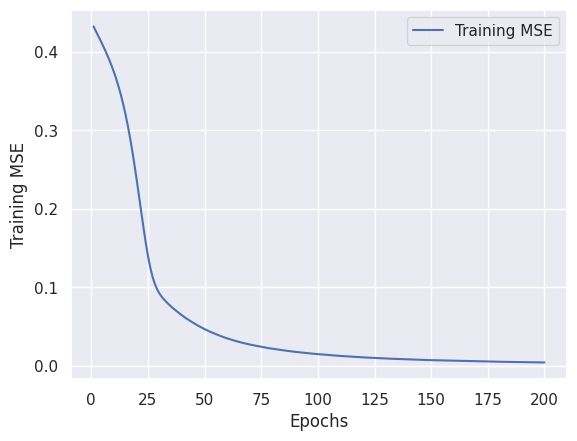

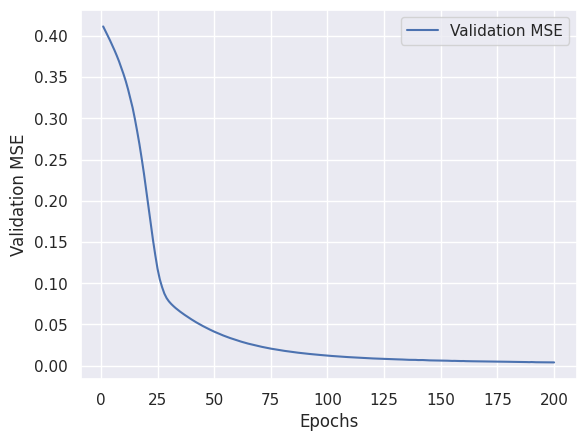

1/1 [==============================] - 0s 22ms/step
<<<<<<=======================================>>>>>>
Mean Squared Error (Training): 0.004186186806920659
Mean Squared Error (Testing): 0.0023991670359265306
Mean Squared Error (Validation): 0.0038716048832210482
<<<<<<=======================================>>>>>>
1/1 [==============================] - 0s 24ms/step
<========== train : Done ==========>



In [ ]:
model = GenralizedHighwayNetwork(5)
model.summary()
training = DataTraining(model, filtered_frame)
val_data=training.run(False)

In [ ]:
class DGMLayer(tf.keras.layers.Layer):
    def __init__(self, activation='tanh', Z_bais=-2.0, G_bais = -2.0, R_bais = -2.0,**kwargs):
        super(DGMLayer, self).__init__(**kwargs)
        self.activation = tf.keras.activations.get(activation)
        self.Z_bais = Z_bais
        self.G_bais = G_bais
        self.R_bais = R_bais

    def build(self, input_shape):
        input_dim = input_shape[-1]
        # Weight matrices and biases for transformation and carry gates
        self.W_Z = self.add_weight("W_transform", shape=(input_dim, input_dim), trainable=True)
        self.b_Z = self.add_weight("b_transform", shape=(input_dim,), trainable=True)
        self.W_G = self.add_weight("W_carry", shape=(input_dim, input_dim), trainable=True)
        self.b_G = self.add_weight("b_carry", shape=(input_dim,), trainable=True)
        self.W_R = self.add_weight("W_transform_data", shape=(input_dim, input_dim), trainable=True)
        self.b_R = self.add_weight("b_transform_data", shape=(input_dim,), trainable=True)
        self.W_H = self.add_weight("W_transform_data", shape=(input_dim, input_dim), trainable=True)
        self.b_H = self.add_weight("b_transform_data", shape=(input_dim,), trainable=True)
        super(DGMLayer, self).build(input_shape)

    def call(self, inputs):
        # Z gate
        Z_gate = tf.sigmoid(tf.matmul(inputs, self.W_Z) + self.b_Z + self.Z_bais)
        # G gate
        G_gate = tf.sigmoid(tf.matmul(inputs, self.W_G) + self.b_G + self.G_bais)
        # R gate
        R_gate = tf.sigmoid(tf.matmul(inputs, self.W_R) + self.b_R + self.R_bais)
        # H
        H = tf.sigmoid(tf.matmul(inputs * R_gate, self.W_H) + self.b_H)

        output = ((1 - G_gate) * H ) + (Z_gate * inputs)



        return output

    def compute_output_shape(self, input_shape):
        return input_shape

In [ ]:
class DGM:
    def __init__(self, input_dim, hidden_units=[100, 3], output_dim=1,
                 initializer='glorot_normal', activation='tanh', loss='mean_squared_error',
                 learning_rate=0.00001, batchsize=1, epochs = 200):

        self.activation = activation
        self.loss = loss
        self.initializer = initializer
        self.learning_rate = learning_rate
        self.batchsize = batchsize
        self.model = tf.keras.Sequential()
        self.epochs = epochs


        self.model.add(tf.keras.layers.Dense(hidden_units[0], activation=self.activation, input_shape=(input_dim,)))
        for i in range(hidden_units[1]):
          self.model.add(DGMLayer(activation = self.activation))
        self.model.add(tf.keras.layers.Dense(output_dim))

        self.model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=self.learning_rate),
                           loss=self.loss)

    def fit(self, X_train, y_train, epochs = 200, batch_size = 1, verbose = 'auto', validation_data = None):
        history = self.model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=verbose,
                                 validation_data=validation_data)

        val_mse = history.history['loss']
        plt.plot(range(1, epochs + 1), val_mse, label='Training MSE')
        plt.xlabel('Epochs')
        plt.ylabel('Training MSE')
        plt.legend()
        plt.show()

        if validation_data:
            val_mse = history.history['val_loss']
            plt.plot(range(1, epochs + 1), val_mse, label='Validation MSE')
            plt.xlabel('Epochs')
            plt.ylabel('Validation MSE')
            plt.legend()
            plt.show()

    def predict(self, X):
        return self.model.predict(X)

    def evaluate(self, X_test, y_test):
        y_pred = self.predict(X_test)
        mse = mean_squared_error(y_test, y_pred)
        print("<<<<<<============================================================>>>>>>")
        print("Mean Squared Error (MSE):", mse)
        print("<<<<<<============================================================>>>>>>")
        return mse

    def run(self, train, test, val, batch_size = 1, verbose = 'auto'):

      epochs = self.epochs

      input_test, output_test = test
      input_val, output_val = val
      input_train, output_train = train

      self.fit(input_train, output_train, epochs, batch_size, verbose, validation_data = val)

      predictions_train = self.predict(input_train)
      predictions_test = self.predict(input_test)
      predictions_val = self.predict(input_val)


      # Calculate Mean Squared Error
      mse_train = mean_squared_error(output_train, predictions_train)
      mse_test = mean_squared_error(output_test, predictions_test)
      mse_val = mean_squared_error(output_val, predictions_val)

      print("<<<<<<=======================================>>>>>>")
      print("Mean Squared Error (Training):", mse_train)
      print("Mean Squared Error (Testing):", mse_test)
      print("Mean Squared Error (Validation):", mse_val)
      print("<<<<<<=======================================>>>>>>")

      return mse_train, mse_test, mse_val
    def summary(self):
      print(self.model.summary())



Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_7 (Dense)             (None, 100)               600       
                                                                 
 dgm_layer (DGMLayer)        (None, 100)               40400     
                                                                 
 dgm_layer_1 (DGMLayer)      (None, 100)               40400     
                                                                 
 dgm_layer_2 (DGMLayer)      (None, 100)               40400     
                                                                 
 dense_8 (Dense)             (None, 1)                 101       
                                                                 
Total params: 121901 (476.18 KB)
Trainable params: 121901 (476.18 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
<========

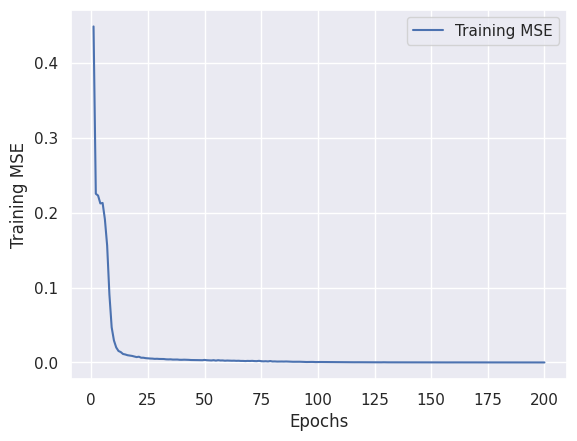

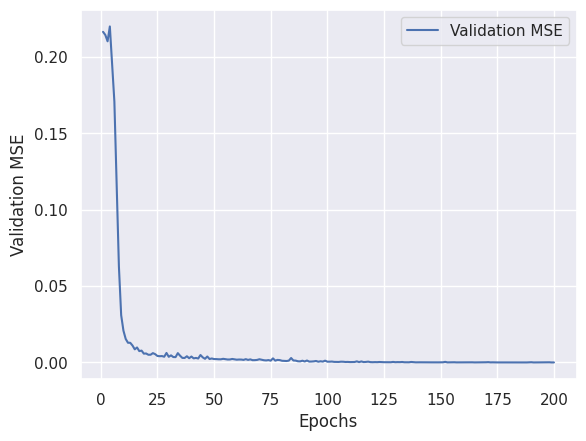

1/1 [==============================] - 0s 21ms/step
<<<<<<=======================================>>>>>>
Mean Squared Error (Training): 4.210316957913786e-05
Mean Squared Error (Testing): 4.003246691050018e-05
Mean Squared Error (Validation): 4.4649274771288674e-05
<<<<<<=======================================>>>>>>
1/1 [==============================] - 0s 22ms/step
<========== train : Done ==========>



In [ ]:
model = DGM(5,learning_rate = 0.0001)
model.summary()
training = DataTraining(model, filtered_frame)
val_data=training.run(False)

In [ ]:
class CONVLSTM:
    def __init__(self, input_shape = (3, 2, 1, 5), output_dim=1,
                 initializer='glorot_normal', activation='tanh', loss='mean_squared_error',
                 learning_rate=0.00001, batchsize=1, epochs = 200):

        self.activation = activation
        self.loss = loss
        self.initializer = initializer
        self.learning_rate = learning_rate
        self.batchsize = batchsize
        self.model = tf.keras.Sequential()
        self.epochs = epochs
        self.input_dim = input_shape

        self.model = tf.keras.Sequential()


        self.model.add(tf.keras.layers.ConvLSTM2D(filters = 64, kernel_size = (1, 3), padding="same"
        , return_sequences=True,activation= self.activation, data_format = "channels_first", input_shape = input_shape))

        self.model.add(tf.keras.layers.ConvLSTM2D(filters = 64, kernel_size = (1, 1), padding="same"
        , return_sequences=True,activation= self.activation, data_format = "channels_first"))

        self.model.add(tf.keras.layers.ConvLSTM2D(filters = 1, kernel_size = (1, 1), padding="same"
        , return_sequences=False ,activation= self.activation, data_format = "channels_first"))

        self.model.add(tf.keras.layers.Flatten(data_format = "channels_first"))

        self.model.add(tf.keras.layers.Dense(1, activation=self.activation))









        self.model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=self.learning_rate),
                           loss=self.loss)

    def fit(self, X_train, y_train, epochs = 200, batch_size = 1, verbose = 'auto', validation_data = None):
        history = self.model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=verbose,
                                 validation_data=validation_data)

        val_mse = history.history['loss']
        plt.plot(range(1, epochs + 1), val_mse, label='Training MSE')
        plt.xlabel('Epochs')
        plt.ylabel('Training MSE')
        plt.legend()
        plt.show()

        if validation_data:
            val_mse = history.history['val_loss']
            plt.plot(range(1, epochs + 1), val_mse, label='Validation MSE')
            plt.xlabel('Epochs')
            plt.ylabel('Validation MSE')
            plt.legend()
            plt.show()

    def predict(self, X):
        return self.model.predict(X)

    def evaluate(self, X_test, y_test):
        y_pred = self.predict(X_test)
        mse = mean_squared_error(y_test, y_pred)
        print("<<<<<<============================================================>>>>>>")
        print("Mean Squared Error (MSE):", mse)
        print("<<<<<<============================================================>>>>>>")
        return mse

    def run(self, train, test, val, batch_size = 1, verbose = 'auto'):

      epochs = self.epochs

      input_test, output_test = test
      input_val, output_val = val
      input_train, output_train = train

      self.fit(input_train, output_train, epochs, batch_size, verbose, validation_data = val)

      predictions_train = self.predict(input_train)
      predictions_test = self.predict(input_test)
      predictions_val = self.predict(input_val)


      # Calculate Mean Squared Error
      mse_train = mean_squared_error(output_train, predictions_train)
      mse_test = mean_squared_error(output_test, predictions_test)
      mse_val = mean_squared_error(output_val, predictions_val)

      print("<<<<<<=======================================>>>>>>")
      print("Mean Squared Error (Training):", mse_train)
      print("Mean Squared Error (Testing):", mse_test)
      print("Mean Squared Error (Validation):", mse_val)
      print("<<<<<<=======================================>>>>>>")

      return mse_train, mse_test, mse_val
    def summary(self):
      self.model.build(input_shape = (3,2,1,5))
      print(self.model.summary())



<========== getOptionsStockDataset : Done ==========>

<========== getBondRateDataframe : Done ==========>

<========== margeLargeAndBond : Done ==========>

<========== filtring : Done ==========>

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_lstm2d_12 (ConvLSTM2D  (None, 3, 64, 1, 5)       50944     
 )                                                               
                                                                 
 conv_lstm2d_13 (ConvLSTM2D  (None, 3, 64, 1, 5)       33024     
 )                                                               
                                                                 
 conv_lstm2d_14 (ConvLSTM2D  (None, 1, 1, 5)           264       
 )                                                               
                                                                 
 flatten_4 (Flatten)         (None, 5)               

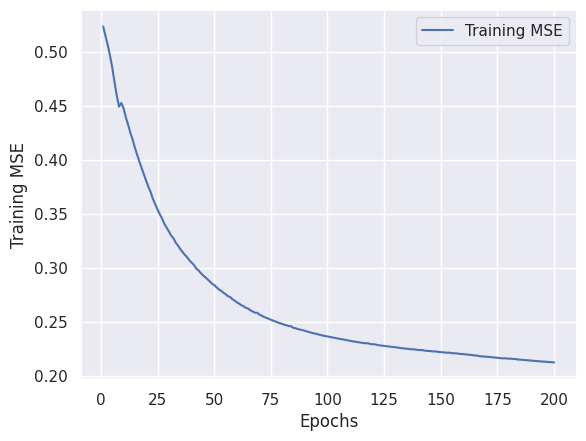

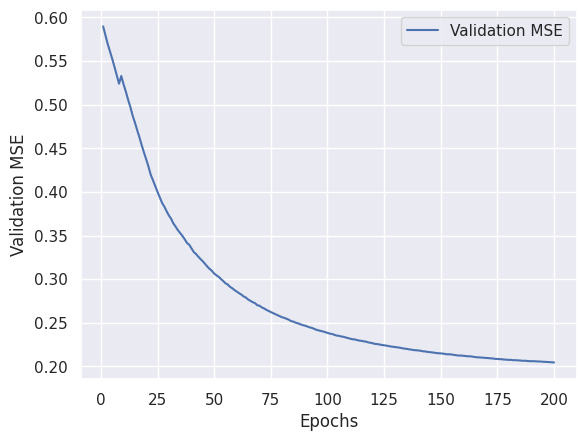

1/1 [==============================] - 0s 24ms/step
<<<<<<=======================================>>>>>>
Mean Squared Error (Training): 0.21244837241056946
Mean Squared Error (Testing): 0.2975280303193332
Mean Squared Error (Validation): 0.20449172450320585
<<<<<<=======================================>>>>>>
1/1 [==============================] - 0s 24ms/step
<========== train : Done ==========>



ValueError: ignored

In [ ]:
# Path to the main folder containing all months
stockPath = '/content/drive/MyDrive/MTP project/Data'
bondRatePath = "/content/Untitled spreadsheet.xlsx"

preprocessing = DatasetPreProcessing(stockPath, bondRatePath, underlying = "AAPL")
filtered_frame = preprocessing.run(no_of_month = 1, min_OI = 0 , min_vOptions = 0)


model = CONVLSTM(learning_rate = 0.0001)
model.summary()
training = DataTraining(model, filtered_frame)
val_data=training.run(True)